# Prédire la consommation d'énergie des bâtiments

## Analyse Exploratoire des Données (EDA)

### Import des modules

In [348]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

### Chargement et premier aperçu des données

In [349]:
building_consumption = pd.read_csv('2016_Building_Energy_Benchmarking.csv')

In [350]:
# On regarde comment un batiment est défini dans ce jeu de données 
building_consumption.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [351]:
# On regarde le nombre de valeurs manquantes par colonne ainsi que leur type 
building_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [352]:
building_consumption.describe(include='all')

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.000000,3376.0,3376,3376,3376,3376,3376,3376,3360.000000,3376,...,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3376,0.0,3376,32,3367.000000,3367.000000
unique,NaN,NaN,8,24,3362,3354,1,1,NaN,3268,...,NaN,NaN,NaN,NaN,2,NaN,4,2,NaN,NaN
top,NaN,NaN,NonResidential,Low-Rise Multifamily,Northgate Plaza,2600 SW Barton St,Seattle,WA,NaN,1625049001,...,NaN,NaN,NaN,NaN,False,NaN,Compliant,Low outlier,NaN,NaN
freq,NaN,NaN,1460,987,3,4,3376,3376,NaN,8,...,NaN,NaN,NaN,NaN,3263,NaN,3211,23,NaN,NaN
mean,21208.991114,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,98116.949107,NaN,...,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,NaN,NaN,NaN,NaN,119.723971,1.175916
std,12223.757015,0.0,NaN,NaN,NaN,NaN,NaN,NaN,18.615205,NaN,...,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,NaN,NaN,NaN,NaN,538.832227,1.821452
min,1.000000,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,98006.000000,NaN,...,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,-0.800000,-0.020000
25%,19990.750000,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,98105.000000,NaN,...,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,9.495000,0.210000
50%,23112.000000,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,98115.000000,NaN,...,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,NaN,NaN,NaN,NaN,33.920000,0.610000
75%,25994.250000,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,98122.000000,NaN,...,8.293178e+05,2.829632e+06,1.189033e+04,1.189034e+06,NaN,NaN,NaN,NaN,93.940000,1.370000


### Nettoyage initial et filtrage

Nous nous concentrons sur les bâtiments non destinés à l'habitation.

In [353]:
print("Nombre de bâtiments:", len(building_consumption))
building_consumption['BuildingType'].value_counts()

Nombre de bâtiments: 3376


BuildingType
NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: count, dtype: int64

In [354]:
residential_building_types = [
    'Multifamily LR (1-4)',
    'Multifamily MR (5-9)',
    'Multifamily HR (10+)'
]

# conserver uniquement les bâtiments NON résidentiels
df_non_residential = building_consumption[
    ~building_consumption['BuildingType'].isin(residential_building_types)
].copy()

print("Nombre de bâtiments non résidentiels :", len(df_non_residential))
print(df_non_residential['BuildingType'].value_counts())

Nombre de bâtiments non résidentiels : 1668
BuildingType
NonResidential        1460
SPS-District K-12       98
Nonresidential COS      85
Campus                  24
Nonresidential WA        1
Name: count, dtype: int64


### Analyse des variables cibles

Les deux variables cibles potentielles sont `SiteEnergyUse(kBtu)` et `SiteEnergyUseWN(kBtu)`. Nous allons les analyser pour choisir celle que nous prédirons.

In [355]:
df=df_non_residential
targets = ['SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)']
df[targets].describe()

,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu)
count,1.666000e+03,1.665000e+03
mean,8.437933e+06,8.064790e+06
std,3.024380e+07,2.203878e+07
min,0.000000e+00,0.000000e+00
25%,1.229291e+06,1.294615e+06
50%,2.554947e+06,2.685146e+06
75%,6.913348e+06,7.109712e+06
max,8.739237e+08,4.716139e+08


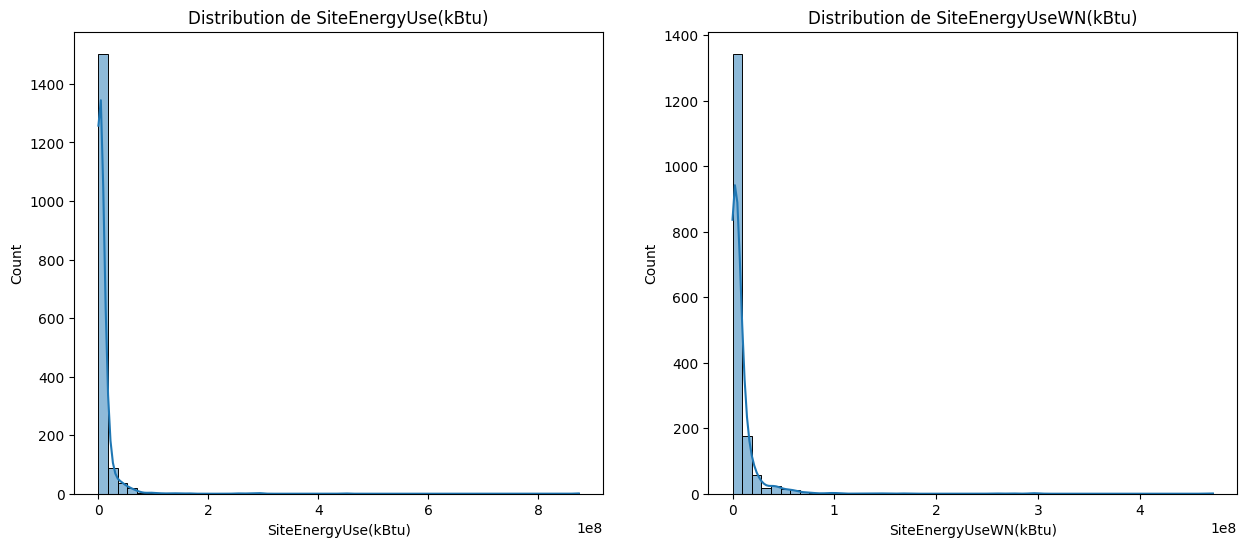

In [356]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(df['SiteEnergyUse(kBtu)'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribution de SiteEnergyUse(kBtu)')
sns.histplot(df['SiteEnergyUseWN(kBtu)'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribution de SiteEnergyUseWN(kBtu)')
plt.show()

Les distributions sont très étalées vers la droite, ce qui indique la présence de valeurs extrêmes. Une transformation logarithmique peut aider à visualiser les données plus clairement et à normaliser la distribution pour certains modèles.

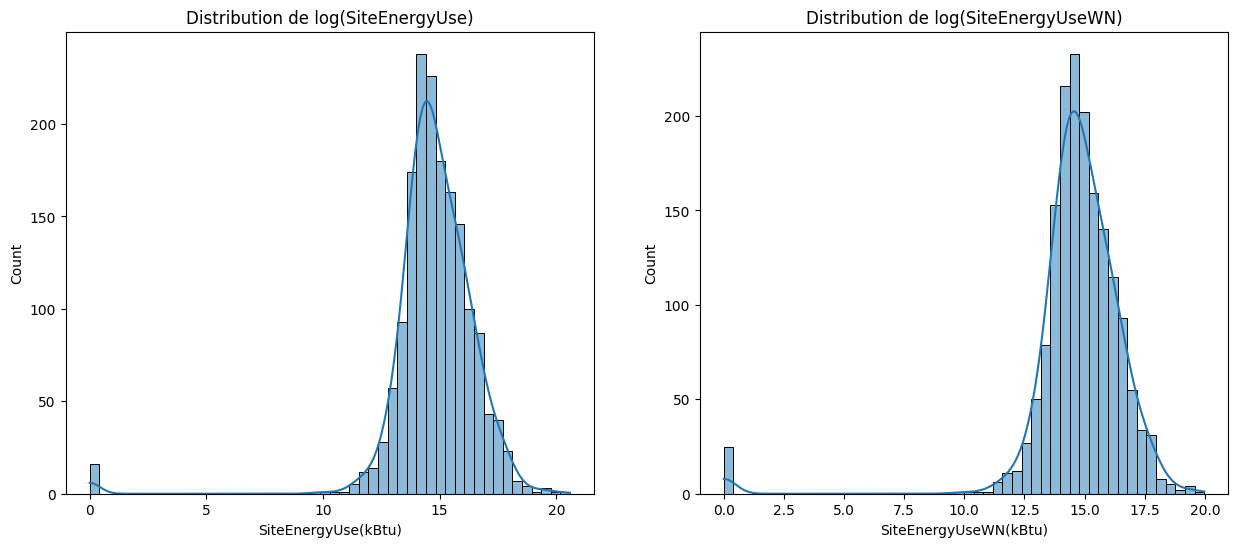

In [357]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(np.log1p(df['SiteEnergyUse(kBtu)']), bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribution de log(SiteEnergyUse)')
sns.histplot(np.log1p(df['SiteEnergyUseWN(kBtu)']), bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribution de log(SiteEnergyUseWN)')
plt.show()

Nous choisissons **SiteEnergyUse(kBtu)** comme variable cible pour le reste du projet.

### Gestion des valeurs manquantes et des outliers

In [358]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_table = pd.concat([missing, missing_percent], axis=1, keys=['Total', 'Pourcentage'])
display(missing_table[missing_table['Total'] > 0].sort_values('Pourcentage', ascending=False))

,Total,Pourcentage
Comments,1668,100.000000
Outlier,1651,98.980815
YearsENERGYSTARCertified,1570,94.124700
ThirdLargestPropertyUseType,1315,78.836930
ThirdLargestPropertyUseTypeGFA,1315,78.836930
SecondLargestPropertyUseType,813,48.741007
SecondLargestPropertyUseTypeGFA,813,48.741007
ENERGYSTARScore,574,34.412470
ZipCode,16,0.959233
LargestPropertyUseTypeGFA,6,0.359712


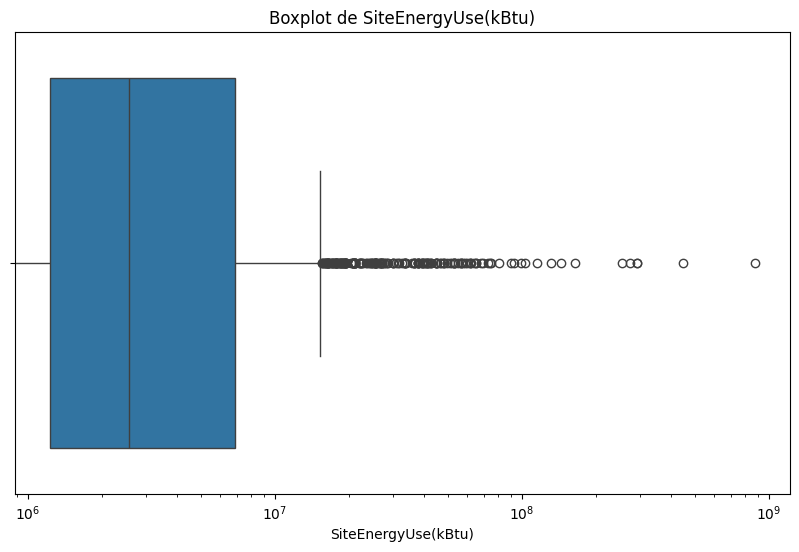

In [359]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['SiteEnergyUse(kBtu)'], whis=1.5)
plt.title('Boxplot de SiteEnergyUse(kBtu)')
plt.xscale('log') 
plt.show()

In [360]:
# Identifier les outliers extrêmes
Q1 = df['SiteEnergyUse(kBtu)'].quantile(0.25)
Q3 = df['SiteEnergyUse(kBtu)'].quantile(0.75)
IQR = Q3 - Q1

outliers = df[df['SiteEnergyUse(kBtu)'] > Q3 + 3*IQR]
print(f"Nombre d'outliers extrêmes : {len(outliers)}")
print(f"\nCaractéristiques de ces bâtiments :")
print(outliers[['BuildingType', 'PropertyGFATotal', 'SiteEnergyUse(kBtu)']].head())

Nombre d'outliers extrêmes : 114

Caractéristiques de ces bâtiments :
      BuildingType  PropertyGFATotal  SiteEnergyUse(kBtu)
2   NonResidential            956110           72587024.0
11  NonResidential            333176           26941110.0
17  NonResidential            416281           33556756.0
20  NonResidential            540360           44984468.0
21  NonResidential            385274           47859812.0


## Feature Engineering & Préparation des données

### Création de nouvelles features

In [361]:
# Âge du bâtiment
if "YearBuilt" in df.columns:
    df['BuildingAge'] = 2016 - df['YearBuilt']

# Ratio énergie / surface totale
if {"SiteEnergyUse(kBtu)", "PropertyGFATotal"}.issubset(df.columns):
     df["EnergyPerSqft"] = df["SiteEnergyUse(kBtu)"] / df["PropertyGFATotal"].replace(0, np.nan)   

# Distance approximative au centre-ville de Seattle
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # rayon terrestre en km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))
if {"Latitude", "Longitude"}.issubset(df.columns):
     df["DistanceFromCenter"] = haversine(df["Latitude"], df["Longitude"], 47.6062, -122.3321)

### Suppression des colonnes non pertinentes

In [362]:
columns_to_drop = [
    'OSEBuildingID', 'DataYear', 'BuildingType', 'Latitude', 'Longitude', 'PropertyName', 'Address', 'City', 'State',
    'ZipCode', 'CouncilDistrictCode', 'YearBuilt', 'TaxParcelIdentificationNumber', 'YearsENERGYSTARCertified',
    'ThirdLargestPropertyUseType', 'NumberofBuildings', 'ThirdLargestPropertyUseTypeGFA', 'Neighborhood', 
    'ListOfAllPropertyUseTypes', 'Comments', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
    'ComplianceStatus', 'Outlier', 'DefaultData', 'SteamUse(kBtu)', 'SecondLargestPropertyUseType', 
    'SecondLargestPropertyUseTypeGFA', 'SiteEUI(kBtu/sf)', 'PropertyGFAParking', 'GHGEmissionsIntensity'
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
print(f"Dimensions après suppression de colonnes : {df.shape}")

Dimensions après suppression de colonnes : (1668, 17)


### Gestion des outliers

In [363]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], lower, upper)
print(f"Taille après suppression des outliers : {len(df)}")

Taille après suppression des outliers : 1668


### Imputation des valeurs manquante

In [364]:
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].fillna(df[col].median())
    else:
        if not df[col].mode().empty:
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna("Inconnu")
print(f"Taille finale après toutes les suppressions : {df.shape}")
print(f"Nombre de valeurs manquantes restantes : {df.isnull().sum().sum()}")

Taille finale après toutes les suppressions : (1668, 17)
Nombre de valeurs manquantes restantes : 0


### Visualisation des features


Dimensions finales du jeu de données : (1668, 17)


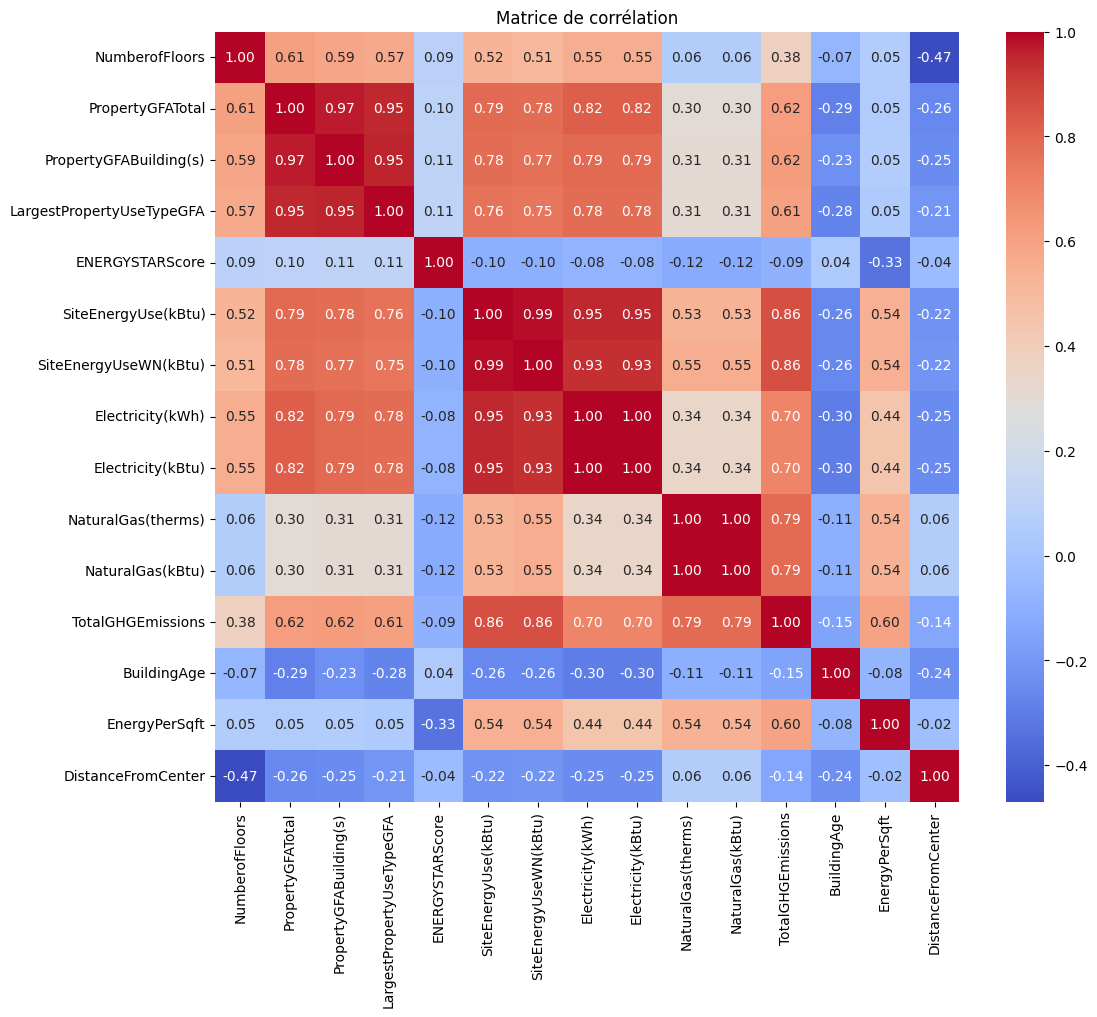

In [365]:
df.dropna(inplace=True)
print(f'\nDimensions finales du jeu de données : {df.shape}')

corr_matrix = df.select_dtypes(include=np.number).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()

In [366]:
df.drop(columns='EnergyPerSqft', inplace=True, errors='ignore')

La features **EnergyPerSqft** a été supprimée pour éviter la fuite de données.

### Sauvegarde du jeu de données préparé

In [367]:
df_prepared = df.copy()
df_prepared.to_csv('prepared_dataset.csv', index=False)

## Préparation des features pour la modélisation

### Import des modules 

In [368]:
#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

### Chargement des données préparées

In [369]:
df_model = pd.read_csv('prepared_dataset.csv')

In [370]:
TARGET = 'SiteEnergyUse(kBtu)'
X = df_model.drop(columns=[TARGET])
y = df_model[TARGET]

y = np.log1p(y)

### Identification des types de features

In [371]:
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

print(f"Features numériques ({len(numerical_features)}): {numerical_features}")
print(f"Features catégorielles ({len(categorical_features)}): {categorical_features}")

Features numériques (13): ['NumberofFloors', 'PropertyGFATotal', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'TotalGHGEmissions', 'BuildingAge', 'DistanceFromCenter']
Features catégorielles (2): ['PrimaryPropertyType', 'LargestPropertyUseType']


### Création du pipeline de pré-traitement

In [372]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
)

### Division en jeux d'entraînement et de test

In [373]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Taille de X_train : {X_train.shape}")
print(f"Taille de X_test : {X_test.shape}")

Taille de X_train : (1334, 15)
Taille de X_test : (334, 15)


## Comparaison de plusieurs modèles supervisés

In [374]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVR': SVR()
}

results_list = []
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    scoring = ['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']
    scores = cross_validate(pipeline, X_train, y_train, cv=5, scoring=scoring, n_jobs=-1)
    
    results_list.append({
        'Modèle': name,
        'R2': scores['test_r2'].mean(),
        'MAE': -scores['test_neg_mean_absolute_error'].mean(),
        'RMSE': -scores['test_neg_root_mean_squared_error'].mean()
    })
    
results_df = pd.DataFrame(results_list)
results_df.set_index('Modèle', inplace=True)
results_df

,R2,MAE,RMSE
Modèle,,,
Linear Regression,0.411814,0.674834,1.428968
Random Forest,0.949303,0.074383,0.390207
SVR,0.524898,0.279346,1.280996


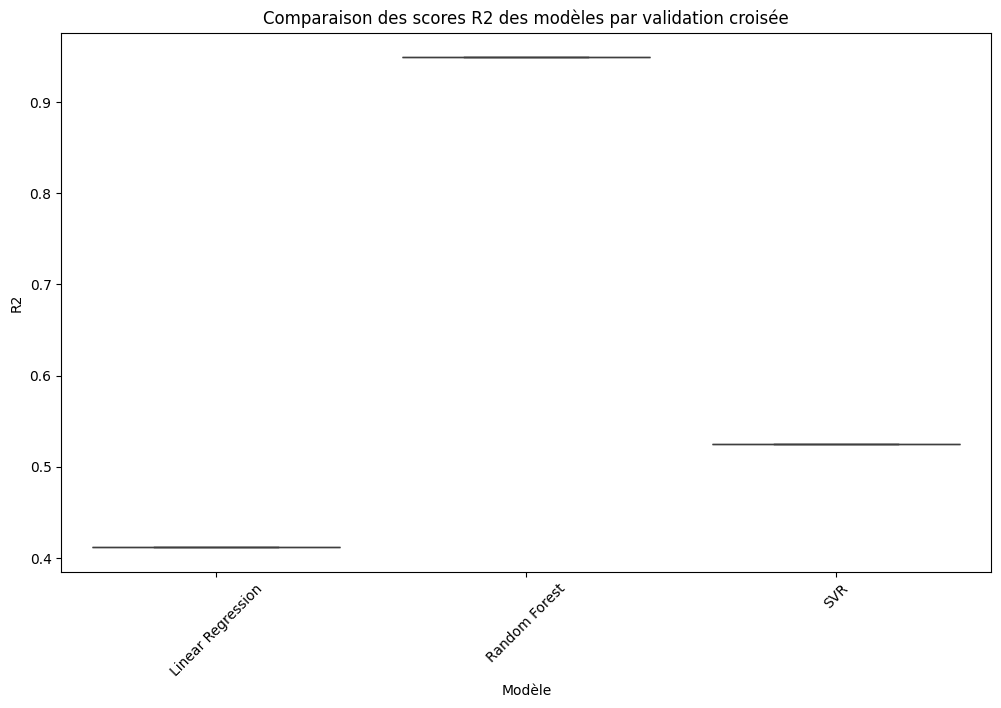

In [375]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Modèle', y='R2', data=results_df)
plt.title('Comparaison des scores R2 des modèles par validation croisée')
plt.xticks(rotation=45)
plt.show()

Le modèle **Random Forest** semble être le plus performant et le plus stable. Nous allons donc l'optimiser.

## Optimisation et interprétation du modèle

### Optimisation avec GridSearchCV

In [376]:
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor), 
                             ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))])

param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20],
    'regressor__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(pipeline_rf, param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'regressor__max_depth': [10, 20], 'regressor__min_samples_split': [2, 5], 'regressor__n_estimators': [100, 200]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [377]:
print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleur score R2 (CV) : {grid_search.best_score_:.4f}")

Meilleurs paramètres : {'regressor__max_depth': 20, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Meilleur score R2 (CV) : 0.9370


### Évaluation finale sur le jeu de test

In [378]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Performance du modèle final sur l'ensemble de test :")
print(f"R2 Score : {r2:.4f}")
print(f"MAE : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")

Performance du modèle final sur l'ensemble de test :
R2 Score : 0.8205
MAE : 0.0998
RMSE : 0.6782


### Interprétation : Importance des features

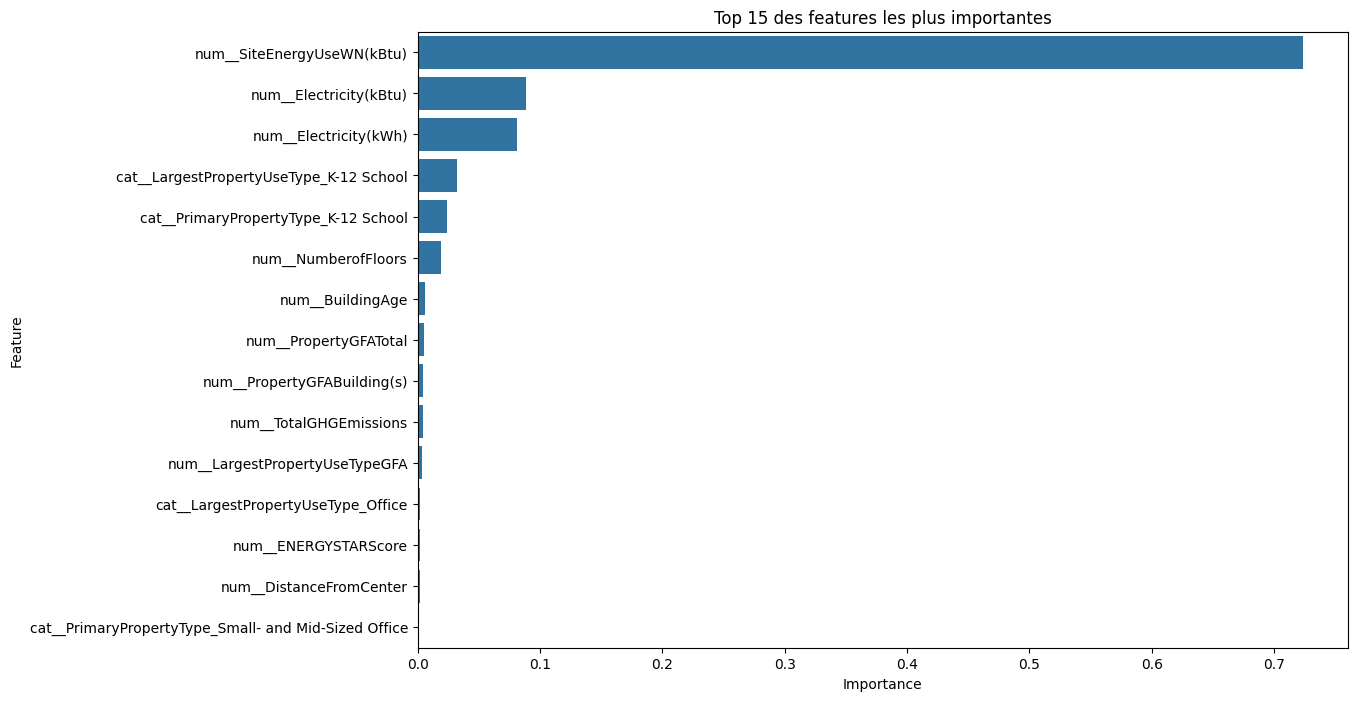

In [382]:
importances = best_model.named_steps['regressor'].feature_importances_
all_feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names, 
    'Importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Top 15 des features les plus importantes')
plt.show()

# Conclusion

Nous avons développé un modèle Random Forest très performant (R² ≈ 0.94) et fiable pour prédire la consommation d'énergie. L'analyse a confirmé que la surface, le type de bâtiment et sa performance énergétique sont les principaux leviers.